In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import pandas as pd
import numpy as np
import math,scipy
import matplotlib as mpl, matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,auc, mean_squared_error,accuracy_score
# # from pyspark import SparkContext
# from pyspark.mllib.stat import Statistics


from utils.PLOTS import *
from utils.fastML import *

In [21]:
df_diff = pd.read_csv('./webApp/upload_file/matrix/classification_test/classification_test.csv')
df_train = pd.read_csv('./webApp/output_result/matrix/classification_test/df_train.csv',index_col=0)
df_test = pd.read_csv('./webApp/output_result/matrix/classification_test/df_test.csv',index_col=0)


In [285]:
df_test['pred'] = [0 if x=='s1' else 1 for x in df_test['pred']]

In [286]:
df_train['pred'] = [0 if x=='s1' else 1 for x in df_train['pred']]
df_diff['pred'] = [0 if x=='s1' else 1 for x in df_diff['pred']]

In [22]:
allauc={}
for gene in df_diff.columns.drop('pred'):
    fpr,tpr,threshold = roc_curve(df_train['pred'],df_train[gene].astype('float'))
    geneauc = auc(fpr,tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    allauc[gene] = (geneauc,optimal_fpr,optimal_tpr,optimal_threshold)

In [23]:
sortauc = dict(sorted(allauc.items(),key=lambda x:x[1][0],reverse=True))
sortauc = {k:v for k, v in sortauc.items() if v[0]>=0.6}

In [24]:
sortauc

{'f1031': (0.6677927927927927,
  0.32894736842105265,
  0.7252252252252253,
  0.0239974239940066),
 'f878': (0.667713766397977,
  0.34210526315789475,
  0.7477477477477478,
  -0.0596853068473637),
 'f481': (0.6677137663979769,
  0.35526315789473684,
  0.7522522522522522,
  -0.0852696073026328),
 'f4738': (0.6667456930614825,
  0.4298245614035088,
  0.8153153153153153,
  -0.3720531739331097),
 'f5106': (0.6663703176861072,
  0.34649122807017546,
  0.7342342342342343,
  -0.0440568948394494),
 'f1322': (0.6662320214951793,
  0.42105263157894735,
  0.8198198198198198,
  -0.3657476515672023),
 'f4169': (0.6662320214951793,
  0.4342105263157895,
  0.8198198198198198,
  -0.417981331115334),
 'f1156': (0.6661925082977713,
  0.33771929824561403,
  0.7477477477477478,
  -0.0537291051372167),
 'f52': (0.6661727516990675,
  0.35526315789473684,
  0.7432432432432432,
  -0.0411542391924583),
 'f963': (0.6658368895211,
  0.41228070175438597,
  0.8198198198198198,
  -0.3255690919444209),
 'f3398': (0.

In [25]:
dfcor = pd.DataFrame()
dfcorp = pd.DataFrame()
for i in list(sortauc.keys()):
    for j in list(sortauc.keys()):
        dfcor.loc[i,j],dfcorp.loc[i,j] = scipy.stats.pearsonr(df_train[i].astype('float64'),df_train[j].astype('float64'))
        

In [26]:
corcopy = dfcorp
keys = list(sortauc.keys())
while keys:
    gene = keys.pop(0)
    filtergenes = list(corcopy[gene].drop(gene).index[abs(corcopy[gene].drop(gene))<0.05])
    corcopy=corcopy.drop(filtergenes)
    while filtergenes:
        filtergene = filtergenes.pop()
        sortauc.pop(filtergene)
        keys.remove(filtergene)

In [27]:
len(sortauc)

2

In [28]:
sortroc = pd.DataFrame(sortauc,index = ['train_auc','train_fpr','train_tpr','train_threshold']).T

In [29]:
sortroc

,train_auc,train_fpr,train_tpr,train_threshold
f1031,0.667793,0.328947,0.725225,0.023997
f4953,0.624526,0.219298,0.522523,0.134176


In [30]:
list(sortroc.index)[:]

['f1031', 'f4953']

In [31]:
feature = list(sortroc.index)[:]
feature.sort()
x_train,x_test = df_train[feature].astype('float'),df_test[feature].astype('float')

feature.append('pred')

y_train,y_test = df_train.loc[df_train.index,'pred'],df_test.loc[df_test.index,'pred']
# y_train,y_test = df_train['pred'],df_test['pred']

# df_dat.to_csv(path_or_buf='df_dat+.csv')
# x_train.to_csv(path_or_buf='x_train+.csv')
# x_test.to_csv(path_or_buf='x_test+.csv')
# y_train.to_csv(path_or_buf='y_train+.csv')
# y_test.to_csv(path_or_buf='y_test+.csv')

In [32]:
df_dat=df_test[feature]

begin gridsearchcv-ModelType.LR
finish gridsearchcv-ModelType.LR
begin gridsearchcv-ModelType.KNN
finish gridsearchcv-ModelType.KNN
begin gridsearchcv-ModelType.RF
finish gridsearchcv-ModelType.RF
begin gridsearchcv-ModelType.GBDT
finish gridsearchcv-ModelType.GBDT
begin gridsearchcv-ModelType.LDA
finish gridsearchcv-ModelType.LDA


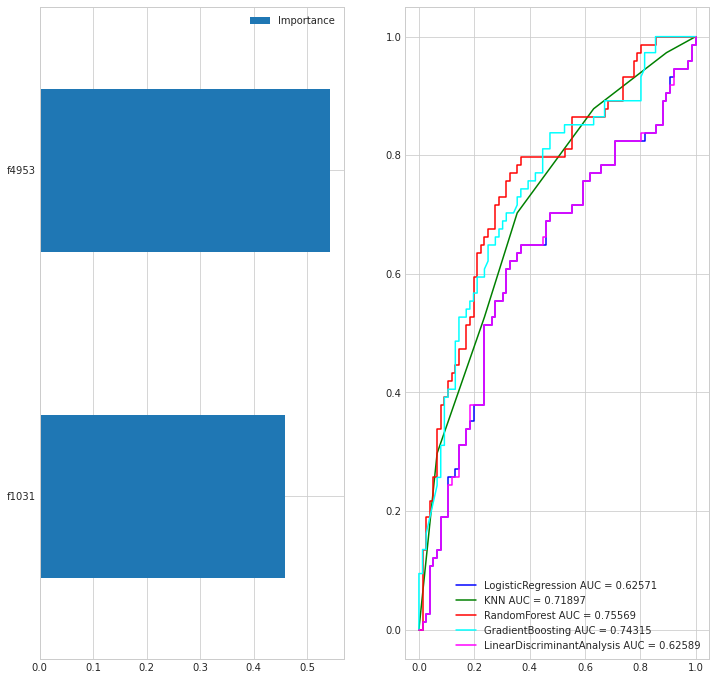

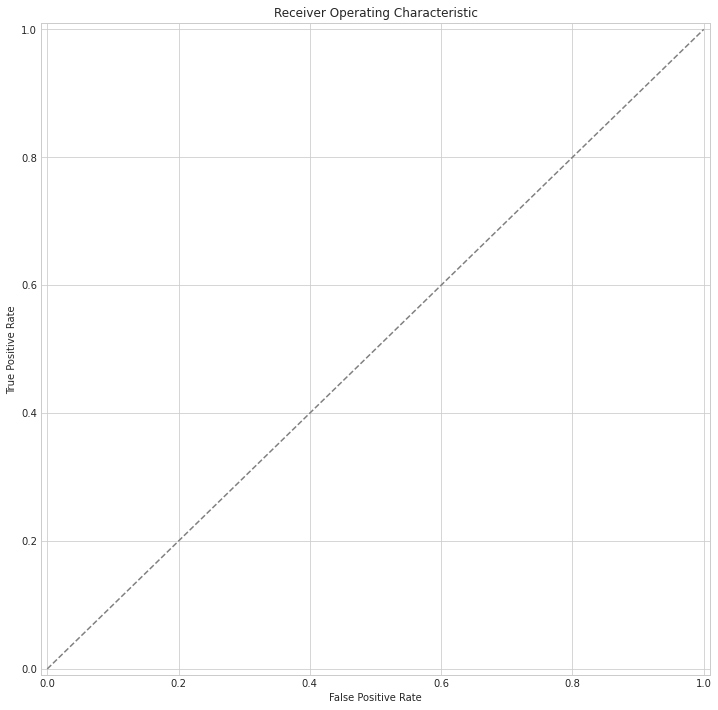

In [38]:
fig = plt.figure(figsize=(12,48))
axes = fig.subplots(nrows=1, ncols=2)
top50_features = Plot_feature_importance(df_dat, 'pred', ax=axes[0])

# selection model
models = Models()
model_scores, model_probs,best_params = fit_and_score(x_train, x_test, y_train, y_test, models)
Plot_ROC_Curves_Web([i.value for i in list(models.keys())], list(model_probs.values()), y_test, ax=axes[1])

In [71]:
list(model_probs.keys())[2]

<ModelType.RF: 'RandomForest'>

In [73]:
model_probs.keys()

dict_keys([<ModelType.LR: 'LogisticRegression'>, <ModelType.KNN: 'KNN'>, <ModelType.RF: 'RandomForest'>, <ModelType.GBDT: 'GradientBoosting'>, <ModelType.LDA: 'LinearDiscriminantAnalysis'>])

In [51]:
modelname = ModelType.RF

In [74]:
 md_test = Biomarker_Evaluate(y_test,model_probs[list(model_probs.keys())[2]])

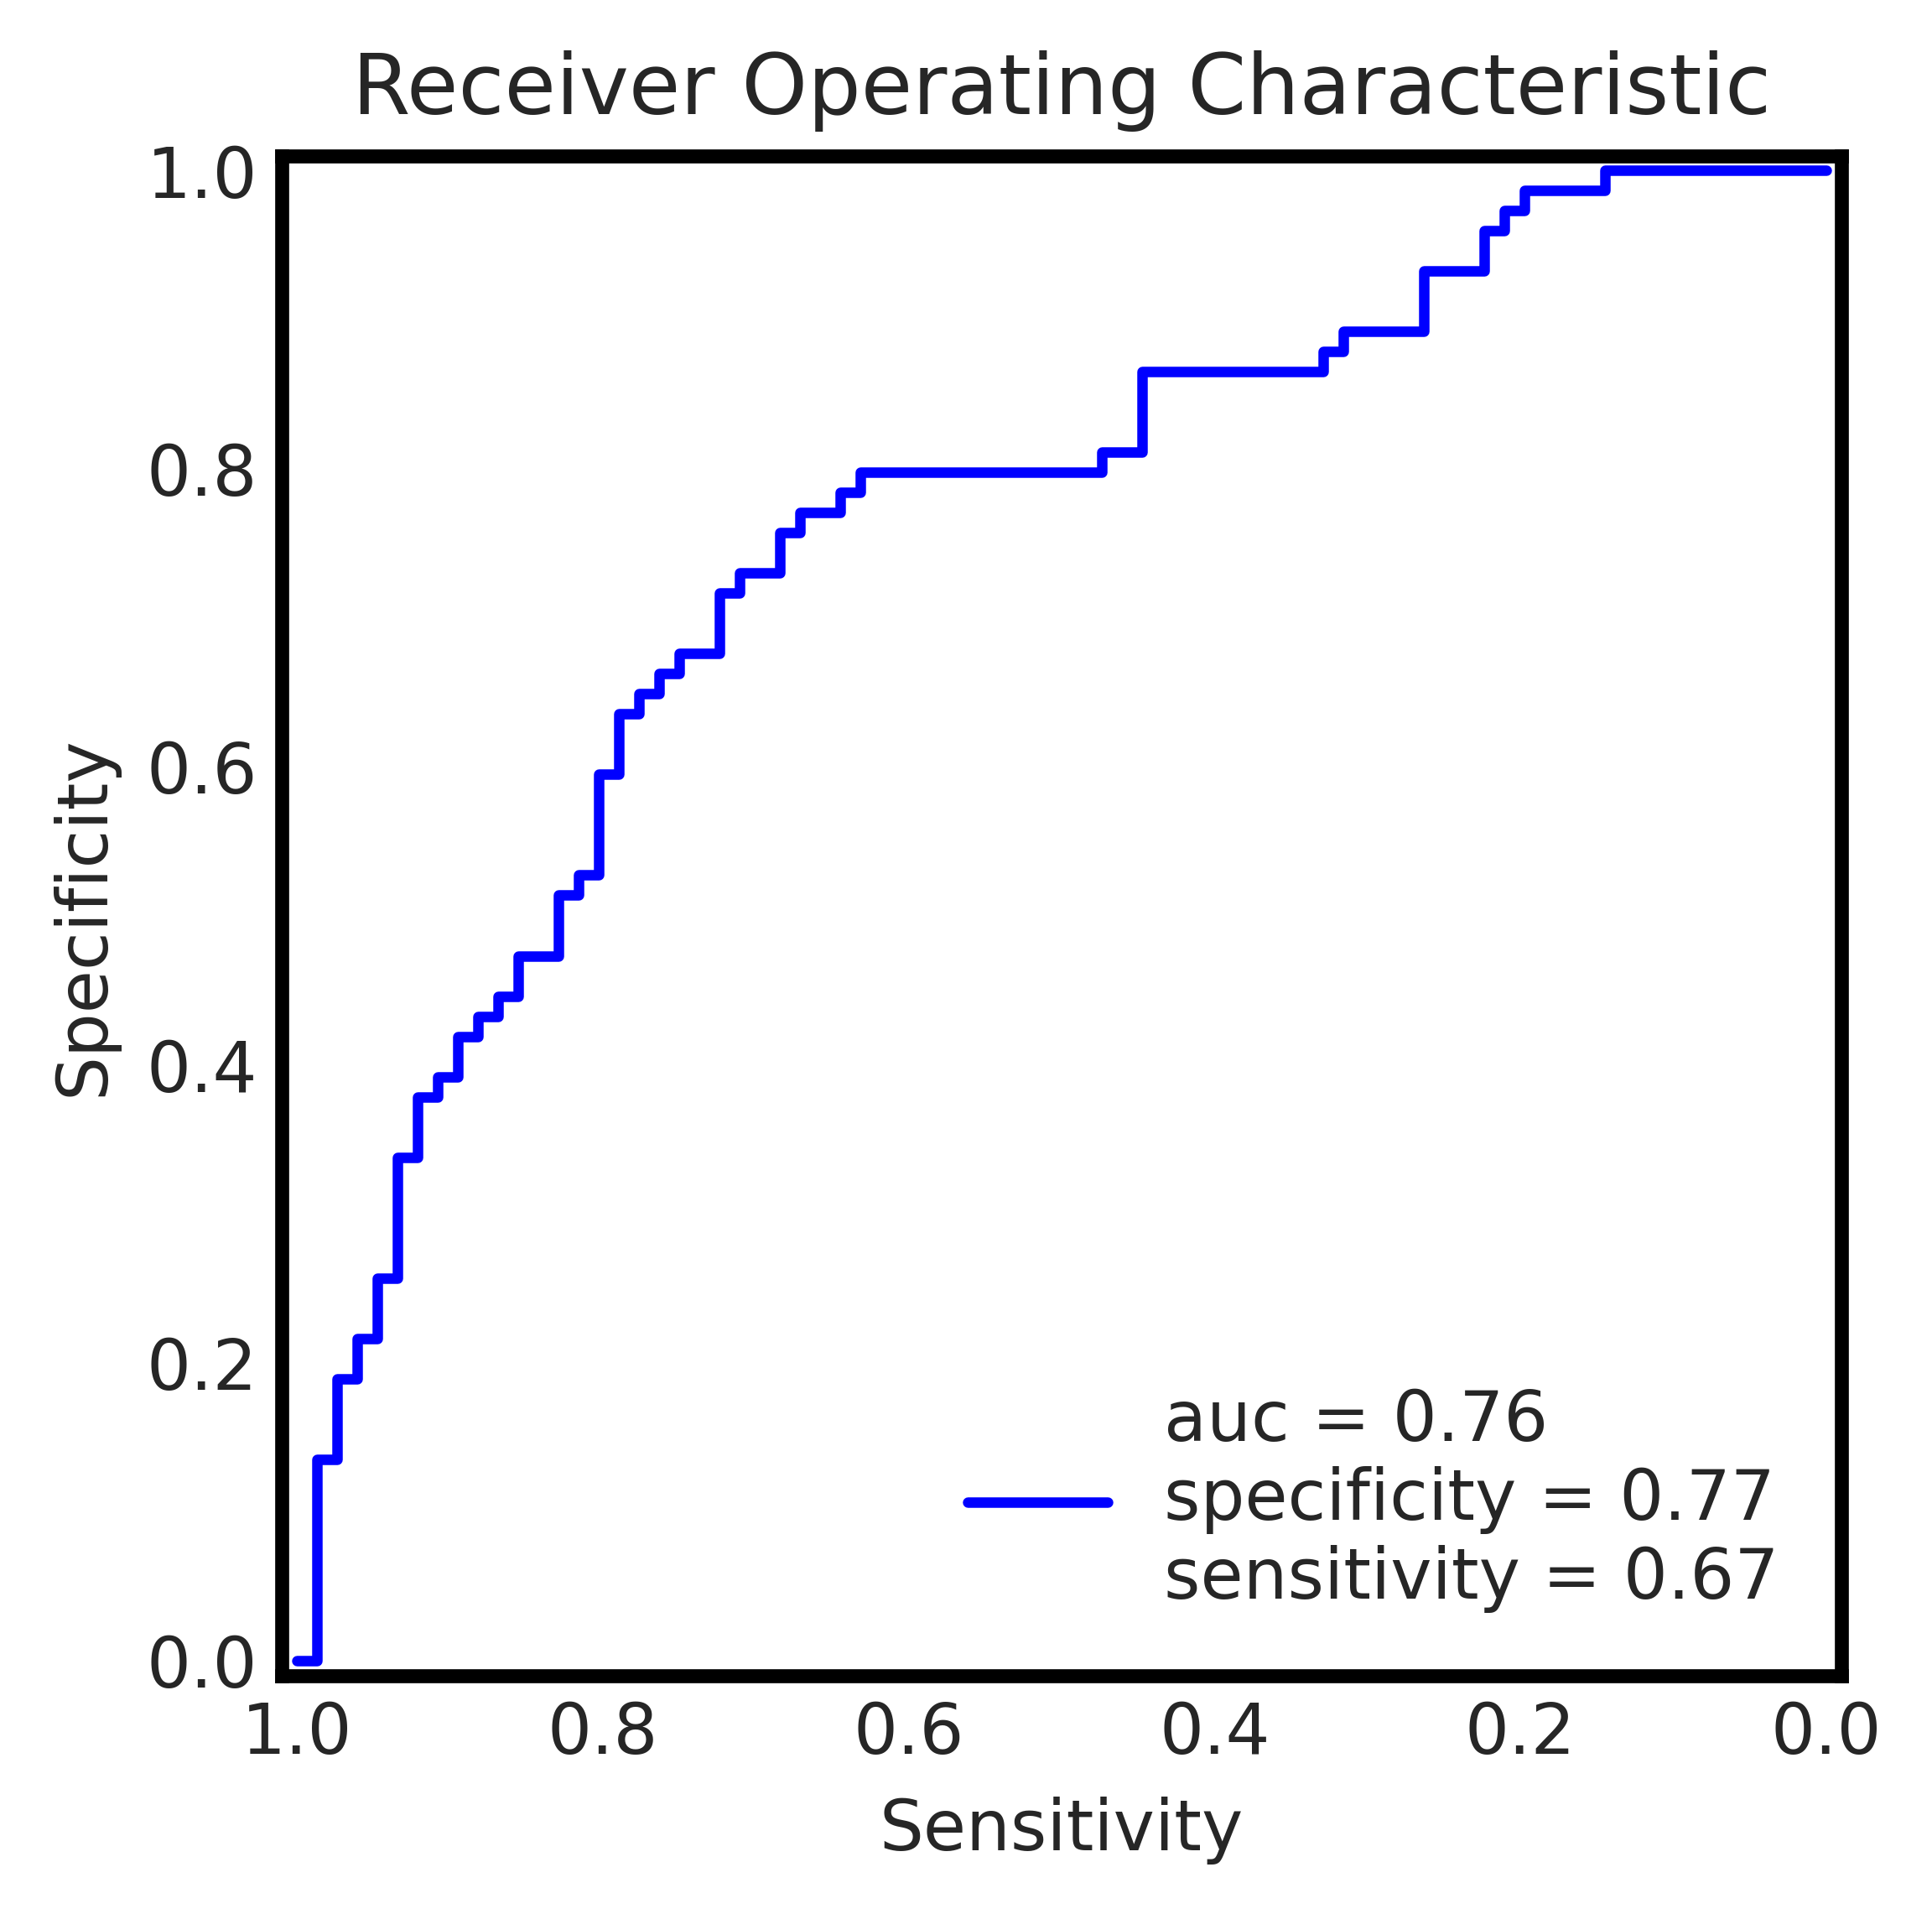

In [75]:
md_test.plot_roc('classtest_baseline.png')

In [374]:
a = {'a':{"A":1,'B':2,'C':3},'b':{"A":4,'B':5,'C':6}}

In [376]:
pd.DataFrame(a)

,a,b
A,1,4
B,2,5
C,3,6


In [403]:
a = [0,0,0,0,1,1,1,1,1]

In [405]:
a.count(1)

5

In [408]:
0==False

True

In [416]:
a=pd.DataFrame(index = pd.MultiIndex.from_product([['Predict'],['1','0']]),
             columns = pd.MultiIndex.from_product([['True Value'],['1','0']]))

In [417]:
a.to_csv(path_or_buf='./a.csv')

In [434]:
a.loc['Predict','1']['True Value','1']

nan

In [40]:
dfcor = pd.DataFrame()

In [46]:
dfcor.loc['b','c'] = 1

In [47]:
dfcor

,b,c
a,1.0,1.0
b,NaN,1.0


In [51]:
df_diff['USP9Y']

GSM3428317    5.240510399
GSM3428319    4.167563333
GSM3428310    1.197649276
GSM3428318    4.718047595
GSM3428328    1.255483785
                 ...     
GSM3428579    1.160519463
GSM3428493    1.479970344
GSM3428552    1.502991808
GSM3428477    1.253722124
GSM3428332    1.475380419
Name: USP9Y, Length: 234, dtype: object

In [71]:
sc = SparkContext()

NameError: name 'SparkContext' is not defined

In [209]:
df_diff

,PID1,FAM20A,JAK3,KLRB1,ADM,ALDH1A1,SOCS3,RUNX2,MS4A4A,MYBL1,...,ZNF565,PPP6R1,TRIB3,NELL2,ALDH5A1,ZMYM1,GFM1,TRIM45,SEL1L3,pred
GSM187612,8.919287538,3.379559621,8.660001247,11.52980714,8.98150524,8.608762299,9.30744271,8.063666133,4.855090858,10.73064839,...,4.643673873,5.110558538,3.480343751,10.23723425,6.925557903,6.911445238,7.07380941,3.850333168,8.542753669,1
GSM187586,8.339965932,3.344095893,8.790798482,11.61115906,7.557974368,8.502104159,7.560458008,7.969752942,4.77459141,10.00975743,...,5.588828235,5.935445322,4.332305565,10.52840061,7.066645165,7.180377589,6.756415693,3.715539389,8.728228589,1
GSM187591,8.804323349,3.264811689,8.781759143,12.20258676,7.690527945,9.420520673,7.992340801,8.447532621,5.511938349,10.23619079,...,5.199816058,5.632218765,4.087593356,10.69809018,6.709304696,6.928253444,6.942575463,4.524108067,8.773580126,1
GSM187595,9.123742472,3.058338456,8.504867268,11.5400171,8.464689643,8.40533071,8.475807336,8.202398553,5.171893056,9.710548079,...,5.352950097,5.233329008,4.198446234,10.27412154,6.659839248,7.06320703,6.883683503,3.584685568,8.162678593,1
GSM187605,9.253130558,3.073032502,8.689848101,12.07098316,9.258917734,10.09918919,8.627859677,8.004311121,4.581421797,10.52718158,...,5.063357431,6.213221166,4.137585008,9.93129764,6.331184168,7.705369647,6.926072266,4.056597763,8.035511966,1
GSM187604,9.239423792,3.258091287,8.593432149,11.13660737,7.936707855,10.25055968,8.935906585,8.067840794,4.566161973,9.883213953,...,4.911709133,5.52968155,3.855761632,10.58700491,6.756012581,6.927480772,7.075362808,3.625306444,8.482049194,1
GSM187584,9.796862821,3.220452853,8.675483988,12.11775594,7.68867887,9.837130577,7.811925168,8.421198982,4.757924432,10.56920689,...,4.931685807,5.44314554,3.625467849,10.39619041,6.757556145,6.671028921,6.868674948,3.617661182,8.415639191,1
GSM187599,8.798722875,3.194839238,8.651167932,11.50283802,8.083017266,8.696519832,7.492129662,8.006359692,5.722676746,10.27519872,...,4.781109981,5.808835637,4.197732464,10.45408646,6.827004373,7.149680945,6.675330776,3.896785236,8.311459448,1
GSM187601,8.400165037,3.481212272,9.016260047,11.70325933,8.670329659,9.45736628,8.880178036,7.796174203,5.679017175,9.946564576,...,5.007127255,5.571118481,3.746582166,9.676692224,6.857266448,6.842697003,7.241863407,4.394114939,8.491543658,1
GSM187611,8.673755749,3.385782753,8.715662464,11.88158751,7.313410987,8.255240199,7.505947349,7.468281308,5.572047406,10.04061506,...,5.10152902,6.3284975,4.309191169,9.964733436,7.049156632,6.777890403,6.832872143,3.688729098,8.580726313,1


In [58]:
scipy.stats.spearmanr(df_diff[i].astype('float64'),df_diff[j].astype('float64'))


SpearmanrResult(correlation=-0.03499926244881044, pvalue=0.5942537387079507)

In [308]:
math.log2(1/1.2)

-0.2630344058337938

In [368]:
StandardScaler().fit_transform(sortroc)

array([[ 1.8025376 , -1.30362898,  0.49629167, -0.33906011],
       [ 1.58194893, -0.9701425 ,  0.49629167,  3.10876111],
       [ 1.10066455, -0.63665602,  0.22333125, -0.37506828],
       [ 0.22833662,  1.03077641,  0.63277188, -0.33763261],
       [ 0.00774795, -0.30316953, -0.45906979, -0.38597447],
       [-0.40334912, -0.63665602, -1.14147083, -0.42393091],
       [-0.71417862,  0.36380344, -0.18610938,  0.25053271],
       [-0.78436592,  0.36380344,  0.08685104, -0.44233012],
       [-0.79439268, -0.9701425 , -2.2333125 , -0.4104003 ],
       [-0.92474053,  1.03077641,  0.22333125, -0.35766116],
       [-1.10020879,  2.03123586,  1.86109375, -0.28723585]])

In [345]:
clf.inverse_transform(sortroc)

array([[ 8.63717718e-01,  1.86147186e-01,  8.13873587e-01,
         6.02547146e+02],
       [ 8.62503033e-01,  1.92946783e-01,  8.13873587e-01,
         2.20910487e+04],
       [ 8.59852812e-01,  1.99746380e-01,  8.10295916e-01,
         3.78126681e+02],
       [ 8.55049285e-01,  2.33744365e-01,  8.15662422e-01,
         6.11444063e+02],
       [ 8.53834600e-01,  2.06545977e-01,  8.01351739e-01,
         3.10154000e+02],
       [ 8.51570869e-01,  1.99746380e-01,  7.92407562e-01,
         7.35909706e+01],
       [ 8.49859268e-01,  2.20145171e-01,  8.04929410e-01,
         4.27717688e+03],
       [ 8.49472777e-01,  2.20145171e-01,  8.08507081e-01,
        -4.10818560e+01],
       [ 8.49417564e-01,  1.92946783e-01,  7.78096879e-01,
         1.57920372e+02],
       [ 8.48699796e-01,  2.33744365e-01,  8.10295916e-01,
         4.86616342e+02],
       [ 8.47733570e-01,  2.54143156e-01,  8.31761941e-01,
         9.25541195e+02]])

In [367]:
clf.inverse_transform(clf.transform(sortroc))

array([[ 9.28571429e-01,  0.00000000e+00,  7.81250000e-01,
         7.20209804e+00],
       [ 9.12202381e-01,  4.76190476e-02,  7.81250000e-01,
         2.79394147e+02],
       [ 8.76488095e-01,  9.52380952e-02,  7.50000000e-01,
         4.35939325e+00],
       [ 8.11755952e-01,  3.33333333e-01,  7.96875000e-01,
         7.31479412e+00],
       [ 7.95386905e-01,  1.42857143e-01,  6.71875000e-01,
         3.49839216e+00],
       [ 7.64880952e-01,  9.52380952e-02,  5.93750000e-01,
         5.01879085e-01],
       [ 7.41815476e-01,  2.38095238e-01,  7.03125000e-01,
         5.37481541e+01],
       [ 7.36607143e-01,  2.38095238e-01,  7.34375000e-01,
        -9.50666667e-01],
       [ 7.35863095e-01,  4.76190476e-02,  4.68750000e-01,
         1.57006863e+00],
       [ 7.26190476e-01,  3.33333333e-01,  7.50000000e-01,
         5.73361765e+00],
       [ 7.13169643e-01,  4.76190476e-01,  9.37500000e-01,
         1.12934216e+01]])